# M2_J008_amazon_fine_dine_reviews

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download snap/amazon-fine-food-reviews

100% 241M/242M [00:01<00:00, 235MB/s]
100% 242M/242M [00:01<00:00, 235MB/s]


In [ ]:
!unzip *.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from collections import defaultdict
from wordcloud import STOPWORDS
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/Reviews.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.drop(['Id','ProductId','UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator','Score','Time','Summary'],axis=1,inplace=True)
df.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


## EDA & PREPROCESS

In [ ]:
df.shape

(568454, 1)

In [ ]:
df.isna().sum()

Text    0
dtype: int64

In [ ]:
print(df.duplicated().sum())
df.drop_duplicates(subset='Text', keep='first',inplace=True)
df.shape

174875


(393579, 1)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [ ]:
def cleanse(string):
    # Lower casing
    string = str(string).lower()

    # Getting rid of mentions
    string = re.sub(r"@\S+", " ", string)

    # Removing HTML
    string = re.sub(r"&.*?;|<.*?>", " ", string)

    # URL removal
    string = re.sub(r"https?://\S+|www\.\S+", " ", string)

    # Handling abbreviations
    # string = convert_abbrev_in_text(string)

    # Non-word removals (special chars)
    string = re.sub(r"[^a-z]", " ", string)

    # Stop word removal
    string = " ".join(word for word in nltk.tokenize.word_tokenize(string) if word not in nltk.corpus.stopwords.words('english'))

    # Lemmatization
    lemma = nltk.stem.WordNetLemmatizer()
    string = " ".join(lemma.lemmatize(word) for word in nltk.tokenize.word_tokenize(string))

    # Single char removal
    string = re.sub(r"\b\w\b", "", string).strip()

    return string

In [ ]:
# Example usage
text_to_clean = "This is an example text with @mentions, <html> tags, and https://example.com links."
cleaned_text = cleanse(text_to_clean)
print(cleaned_text)

example text tag link


In [ ]:
df['cleaned']=df['Text'].apply(cleanse)

In [ ]:
df2 = df.copy()

In [ ]:
df2.to_csv('ReviewsClean.csv',index = False)

In [ ]:
df2.head(10)

,Text,cleaned
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...
2,This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
5,I got a wild hair for taffy and ordered this f...,got wild hair taffy ordered five pound bag taf...
6,This saltwater taffy had great flavors and was...,saltwater taffy great flavor soft chewy candy ...
7,This taffy is so good. It is very soft and ch...,taffy good soft chewy flavor amazing would def...
8,Right now I'm mostly just sprouting this so my...,right mostly sprouting cat eat grass love rota...
9,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...


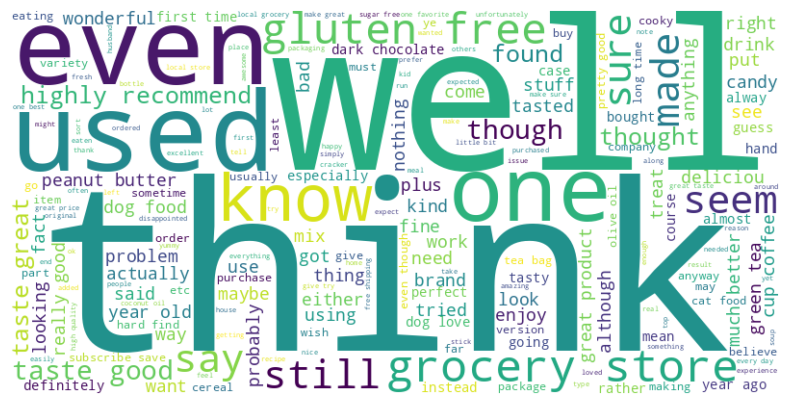

In [ ]:
text_combined = ' '.join(df2['cleaned'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Uni,Bi,Trigrams

In [ ]:
N = 10

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

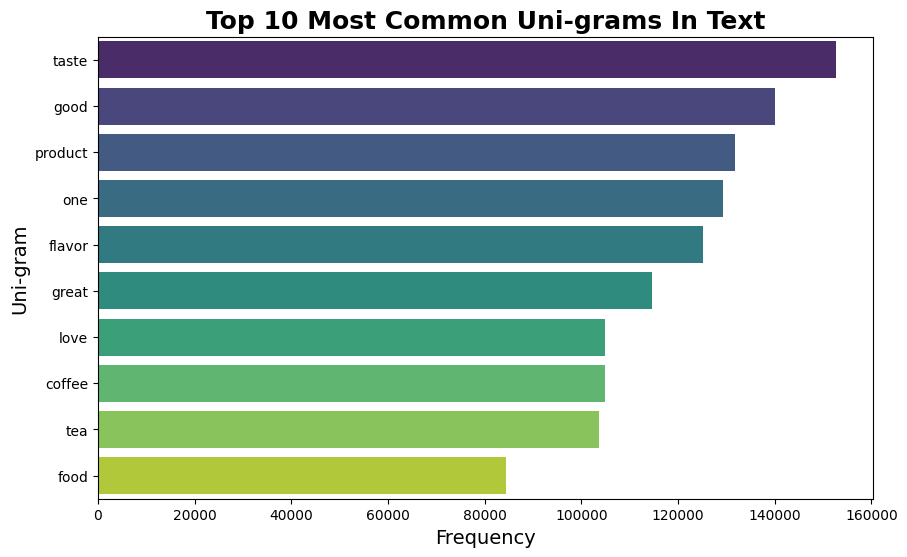

In [ ]:
unigrams = defaultdict(int)
for i in df2['cleaned']:
    for word in generate_ngrams(i, 1):
        unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

# Sort the DataFrame by frequency in descending order and select the top N unigrams
unigrams_less_11 = df_unigrams.sort_values(by=1, ascending=False)[:N]

# Create a horizontal bar plot using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x=unigrams_less_11[1], y=unigrams_less_11[0], palette='viridis')

# Customize the plot
plt.title("Top 10 Most Common Uni-grams In Text", fontsize=18, fontweight='bold')
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Uni-gram", fontsize=14)
plt.show()

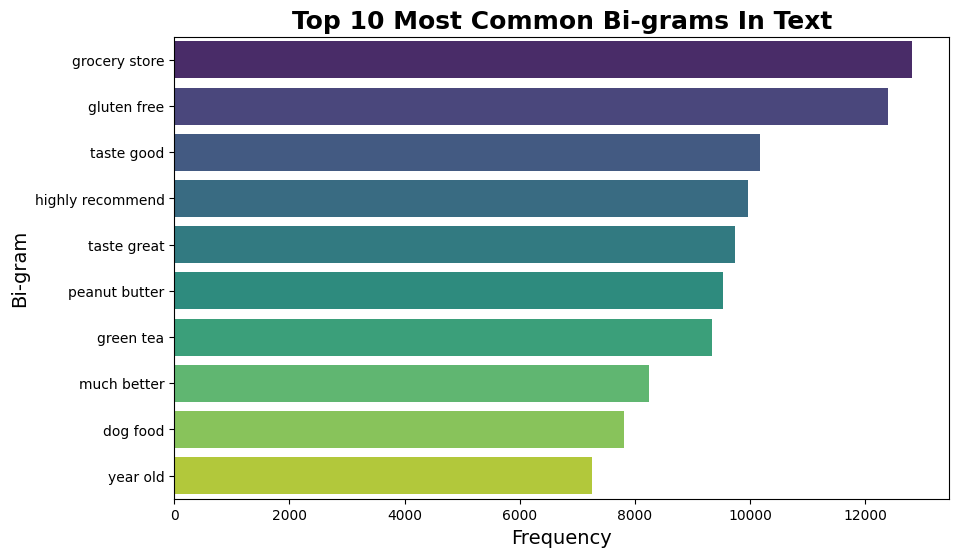

In [ ]:
unigrams = defaultdict(int)
for i in df2['cleaned']:
    for word in generate_ngrams(i, 2):
        unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

# Sort the DataFrame by frequency in descending order and select the top N unigrams
bigrams_less_11 = df_unigrams.sort_values(by=1, ascending=False)[:N]

# Create a horizontal bar plot using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x=bigrams_less_11[1], y=bigrams_less_11[0], palette='viridis')

# Customize the plot
plt.title("Top 10 Most Common Bi-grams In Text", fontsize=18, fontweight='bold')
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Bi-gram", fontsize=14)
plt.show()


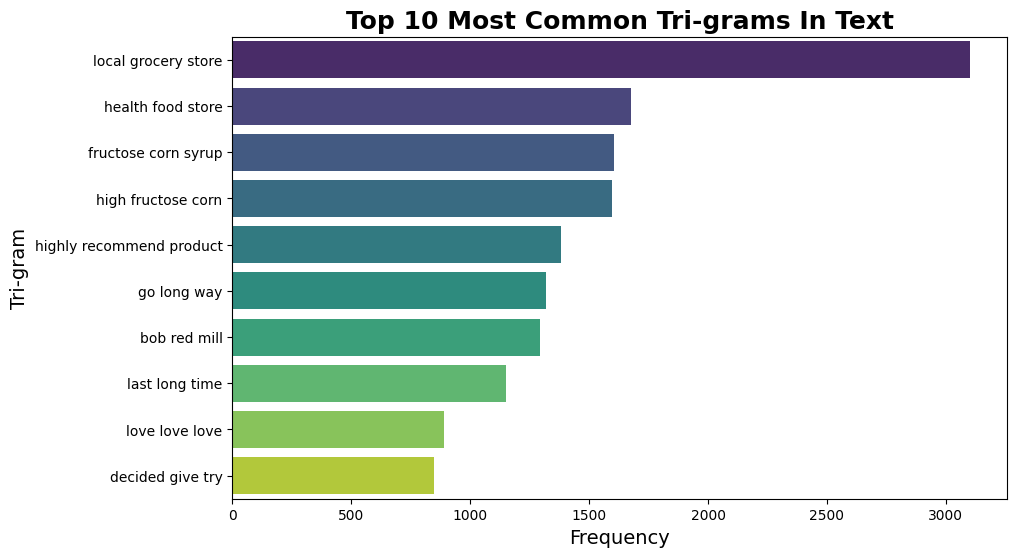

In [ ]:
unigrams = defaultdict(int)
for i in df2['cleaned']:
    for word in generate_ngrams(i, 3):
        unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

# Sort the DataFrame by frequency in descending order and select the top N unigrams
trigrams_less_11 = df_unigrams.sort_values(by=1, ascending=False)[:N]

# Create a horizontal bar plot using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x=trigrams_less_11[1], y=trigrams_less_11[0], palette='viridis')

# Customize the plot
plt.title("Top 10 Most Common Tri-grams In Text", fontsize=18, fontweight='bold')
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Tri-gram", fontsize=14)
plt.show()


# Tf-idf

In [ ]:
vect =TfidfVectorizer(max_df=0.95,min_df=2,stop_words=list(stop_words),max_features=1000)

In [ ]:
vect_text=vect.fit_transform(df2['cleaned'])

In [ ]:
print(vect_text.shape)
print(vect_text)

(393579, 1000)
  (0, 75)	0.36190249665967467
  (0, 797)	0.2392603295367937
  (0, 512)	0.28066572115948346
  (0, 673)	0.3428893597291888
  (0, 470)	0.1221960825414594
  (0, 484)	0.23654254987260223
  (0, 684)	0.22091349393496684
  (0, 366)	0.1293620227222932
  (0, 336)	0.19421299819848462
  (0, 674)	0.41572690067509005
  (0, 332)	0.17834688042833638
  (0, 239)	0.21239804277023372
  (0, 121)	0.30226093357702666
  (0, 764)	0.24771649932346113
  (0, 93)	0.19702774781403584
  (1, 860)	0.2673698552171813
  (1, 790)	0.40162147354370425
  (1, 795)	0.2691501970010162
  (1, 5)	0.28072249316371717
  (1, 620)	0.6447672166653906
  (1, 41)	0.30049940203971637
  (1, 674)	0.3315749560556801
  (2, 755)	0.28313413144827143
  (2, 914)	0.36436082215579674
  (2, 999)	0.23570841451569235
  :	:
  (393576, 427)	0.3007110347272529
  (393576, 914)	0.14927584132717078
  (393576, 795)	0.1533522687378606
  (393576, 797)	0.16309139678126736
  (393576, 470)	0.08329475187745626
  (393576, 332)	0.36470954332819366
  (

In [ ]:
idf=vect.idf_

In [ ]:
dd=dict(zip(vect.get_feature_names_out(), idf))
l=sorted(dd, key=(dd).get)

print(l[0],l[-1])

like trap


In [ ]:
print(dd['like'])
print(dd['trap'])

2.170403020559765
7.007807542584503


# LSA

In [ ]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [ ]:
print(lsa_top.shape)
print(lsa_top)

(393579, 10)
[[ 0.25600471 -0.15528136 -0.08724707 ... -0.10639967  0.30036274
   0.00074538]
 [ 0.11582923 -0.07415849 -0.03765638 ... -0.07350944  0.21012766
  -0.08138592]
 [ 0.09634653 -0.05333172 -0.03396878 ... -0.01742019 -0.0124043
  -0.01638114]
 ...
 [ 0.26586946 -0.20778231 -0.1387796  ... -0.04425128  0.02000985
  -0.02301816]
 [ 0.1544926  -0.11421697 -0.07216748 ... -0.05519854 -0.04600259
   0.03550716]
 [ 0.08594531 -0.04677028 -0.02092259 ... -0.0042275   0.10472295
  -0.07850701]]


In [ ]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  25.600471253452227
Topic  1  :  -15.528135604978768
Topic  2  :  -8.724707200216471
Topic  3  :  14.607938321966959
Topic  4  :  6.378731459903345
Topic  5  :  -10.128612986972838
Topic  6  :  12.88463116835121
Topic  7  :  -10.639966602669386
Topic  8  :  30.036274157196598
Topic  9  :  0.07453802288939389


In [ ]:
for index,topic in enumerate(lsa_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([vect.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['really', 'make', 'get', 'would', 'food', 'one', 'love', 'flavor', 'great', 'product', 'good', 'taste', 'coffee', 'like', 'tea']


THE TOP 15 WORDS FOR TOPIC #2
['bag', 'blend', 'bitter', 'brew', 'drinking', 'leaf', 'iced', 'black', 'strong', 'flavor', 'drink', 'green', 'cup', 'coffee', 'tea']


THE TOP 15 WORDS FOR TOPIC #3
['bitter', 'espresso', 'smooth', 'flavor', 'blend', 'keurig', 'starbucks', 'dark', 'pod', 'bold', 'strong', 'bean', 'roast', 'cup', 'coffee']


THE TOP 15 WORDS FOR TOPIC #4
['year', 'bone', 'toy', 'vet', 'pet', 'chew', 'bag', 'cup', 'love', 'tea', 'cat', 'treat', 'coffee', 'food', 'dog']


THE TOP 15 WORDS FOR TOPIC #5
['item', 'ordered', 'time', 'box', 'grocery', 'local', 'buy', 'shipping', 'order', 'find', 'great', 'store', 'price', 'amazon', 'product']


THE TOP 15 WORDS FOR TOPIC #6
['chip', 'peanut', 'amazon', 'box', 'price', 'dark', 'cooky', 'candy', 'snack', 'great', 'treat', 'love', 'bar', 'dog', 'chocolate']


THE TOP 15 WOR

In [ ]:
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i+1)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 1: 
tea like coffee taste good product great flavor love one 

Topic 2: 
tea coffee cup green drink flavor strong black iced leaf 

Topic 3: 
coffee cup roast bean strong bold pod dark starbucks keurig 

Topic 4: 
dog food coffee treat cat tea love cup bag chew 

Topic 5: 
product amazon price store great find order shipping buy local 

Topic 6: 
chocolate dog bar love treat great snack candy cooky dark 

Topic 7: 
great product dog taste use treat water sauce love drink 

Topic 8: 
great love cat food snack flavor free gluten healthy best 

Topic 9: 
product chocolate taste food bar cat good great tea quality 

Topic 10: 
good taste like price store really buy snack amazon cereal 



# LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1)

In [ ]:
lda_top=lda_model.fit_transform(vect_text)

In [ ]:
print(lda_top.shape)
print(lda_top)

(393579, 10)
[[0.02136106 0.02136107 0.02136366 ... 0.02136558 0.02136414 0.02136802]
 [0.028609   0.02860653 0.02860922 ... 0.3180979  0.45301302 0.0286131 ]
 [0.02209655 0.12399172 0.02210617 ... 0.02210426 0.4424778  0.10119466]
 ...
 [0.01851302 0.01851386 0.07187891 ... 0.01851548 0.01851938 0.01851521]
 [0.02321506 0.02322994 0.02321642 ... 0.02321862 0.31345511 0.02322018]
 [0.0298927  0.14816596 0.02989595 ... 0.02989869 0.39005298 0.02990033]]


In [ ]:
sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)

1.0


In [ ]:
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  2.136106096014303 %
Topic  1 :  2.1361071380176173 %
Topic  2 :  2.1363658384997994 %
Topic  3 :  80.77052609160931 %
Topic  4 :  2.1380488225437215 %
Topic  5 :  2.136495418036506 %
Topic  6 :  2.1365762015657834 %
Topic  7 :  2.136558132403181 %
Topic  8 :  2.136414390714995 %
Topic  9 :  2.1368018705947778 %


In [ ]:
print(lda_model.components_)
print(lda_model.components_.shape)

[[1.00015157e-01 1.00020643e-01 1.00010906e-01 ... 1.00014608e-01
  4.99378644e+02 1.00026202e-01]
 [1.00013815e-01 1.00028873e-01 1.00010472e-01 ... 1.00057906e-01
  1.00014643e-01 6.93749082e+02]
 [1.00030457e-01 1.00039297e-01 1.00014341e-01 ... 1.00014647e-01
  1.00012333e-01 1.00040597e-01]
 ...
 [1.63083974e+02 4.73411998e+02 1.00027863e-01 ... 1.00033286e-01
  1.00017947e-01 1.00037722e-01]
 [8.87031650e+01 2.99108965e+02 1.00021465e-01 ... 1.00129593e-01
  1.00029566e-01 6.67586860e+02]
 [8.78554460e+02 1.00043376e-01 1.00019806e-01 ... 1.00027099e-01
  1.00010105e-01 1.00029570e-01]]
(10, 1000)


In [ ]:
for index,topic in enumerate(lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([vect.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['berry', 'gf', 'pop', 'hooked', 'yum', 'melt', 'craving', 'seed', 'mom', 'ordering', 'cheese', 'licorice', 'thank', 'cracker', 'popcorn']


THE TOP 15 WORDS FOR TOPIC #2
['everyone', 'wine', 'loved', 'wrapped', 'jerky', 'enjoyed', 'kid', 'child', 'party', 'yummy', 'son', 'soft', 'chewy', 'candy', 'cereal']


THE TOP 15 WORDS FOR TOPIC #3
['rice', 'italian', 'puppy', 'com', 'wheat', 'tuna', 'waffle', 'mix', 'cake', 'espresso', 'bread', 'free', 'flour', 'pasta', 'gluten']


THE TOP 15 WORDS FOR TOPIC #4
['would', 'eat', 'year', 'time', 'good', 'get', 'bag', 'like', 'product', 'one', 'treat', 'cat', 'love', 'food', 'dog']


THE TOP 15 WORDS FOR TOPIC #5
['dish', 'pill', 'lime', 'salmon', 'dressing', 'mango', 'lemon', 'meat', 'bone', 'salt', 'chicken', 'salad', 'olive', 'oil', 'soup']


THE TOP 15 WORDS FOR TOPIC #6
['decaf', 'bitter', 'smooth', 'great', 'good', 'blend', 'like', 'green', 'taste', 'drink', 'strong', 'flavor', 'cup', 'coffee', 'tea']


THE TOP 

In [ ]:
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):

    vocab_comp = zip(vocab, comp) # It pairs each term with its importance score in the topic.

    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]

    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
popcorn cracker thank licorice cheese ordering mom seed craving melt 

Topic 1: 
cereal candy chewy soft son yummy party child kid enjoyed 

Topic 2: 
gluten pasta flour free bread espresso cake mix waffle tuna 

Topic 3: 
dog food love cat treat one product like bag get 

Topic 4: 
soup oil olive salad chicken salt bone meat lemon mango 

Topic 5: 
tea coffee cup flavor strong drink taste green like blend 

Topic 6: 
taste like flavor good product water one sauce coffee use 

Topic 7: 
chocolate gift product order arrived received great box good ordered 

Topic 8: 
snack bar great peanut taste cooky good cookie butter love 

Topic 9: 
amazon store price find product local grocery buy great purchase 



In [ ]:
from wordcloud import WordCloud

def draw_word_cloud(index):

    imp_words_topic=""
    comp=lda_model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]
    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Wordcloud for topic 1 is:


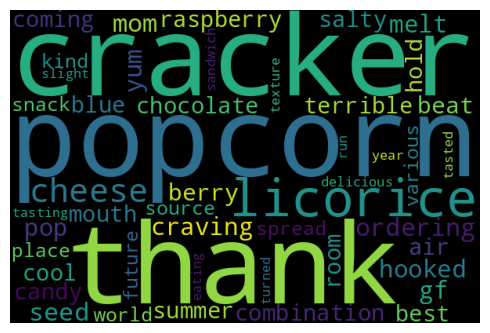

Wordcloud for topic 2 is:


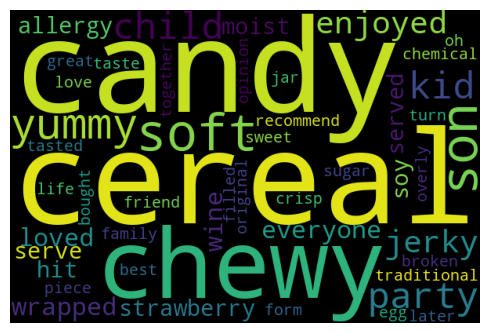

Wordcloud for topic 3 is:


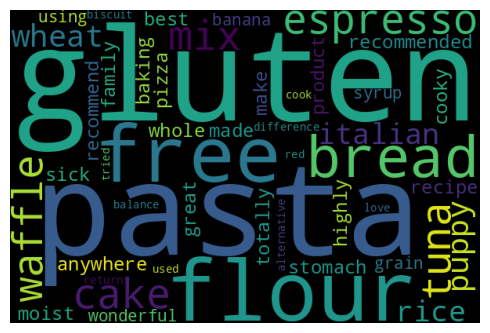

Wordcloud for topic 4 is:


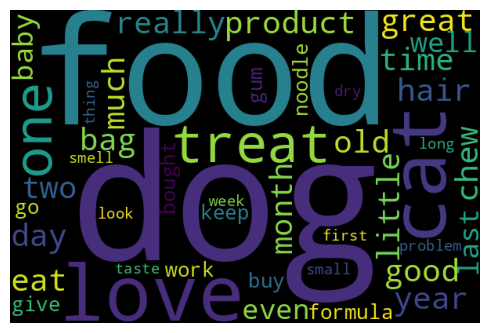

Wordcloud for topic 5 is:


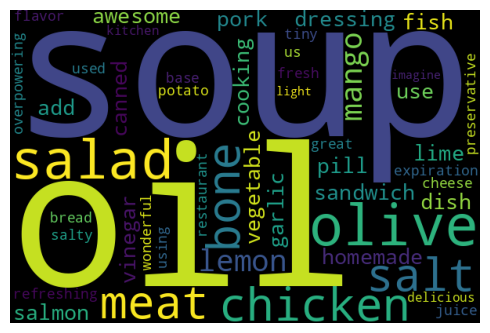

Wordcloud for topic 6 is:


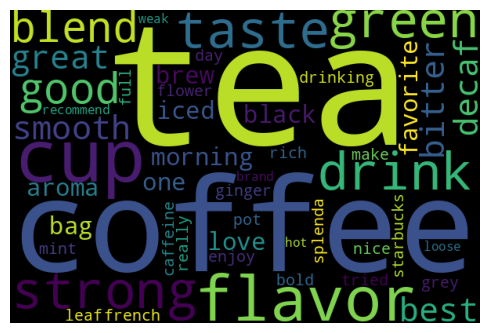

Wordcloud for topic 7 is:


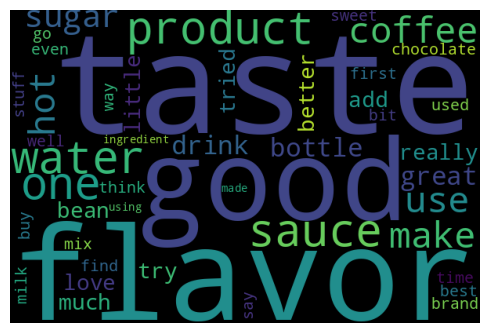

Wordcloud for topic 8 is:


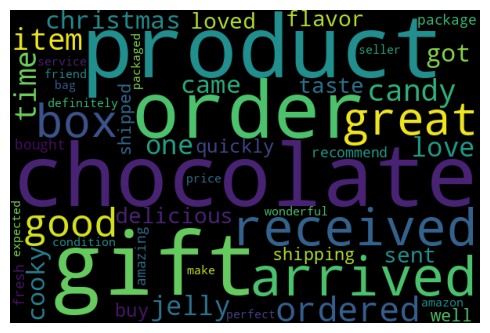

Wordcloud for topic 9 is:


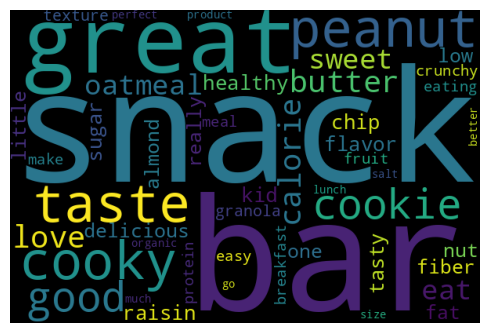

Wordcloud for topic 10 is:


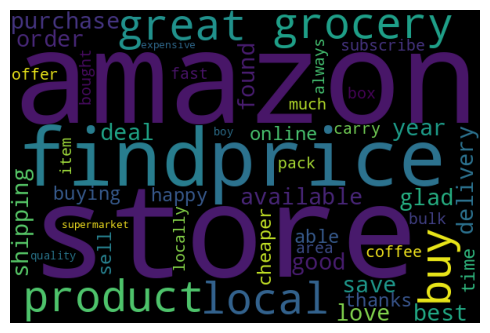

In [ ]:
num_topics = len(lda_model.components_)
for topic_index in range(num_topics):
    print(f"Wordcloud for topic {topic_index+1} is:")
    draw_word_cloud(topic_index)

# BERTopic

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (set

In [ ]:
from bertopic import BERTopic

In [ ]:
docs = list(df2.loc[:,'cleaned'].values)

In [ ]:
docs[:5]

['bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanut peanut actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around century light pillowy citrus gelatin nut case filbert cut tiny square liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story  lewis lion witch wardrobe treat seduces edmund selling brother sister witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [ ]:
topic_model = BERTopic(nr_topics=10)
topics, probs = topic_model.fit_transform(docs)

In [ ]:
topic_model.get_topic_info()

In [ ]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), max_df=0.95, min_df=2)
topic_model.update_topics(docs, vectorizer_model=vectorizer_model) #straight update no need to retrain

In [ ]:
topic_model.get_document_info(docs)

In [ ]:
topic_model.get_topic_freq()

In [ ]:
topic_model.get_topic(3)

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_topics()

In [ ]:
# topic_model.visualize_hierarchy()